In [1]:
import sys
sys.path.append("../..")
import numpy as np
import sklearn.datasets as skd
from tqdm import trange

import logging
logging.getLogger('tensorflow').disabled = True

# visualization
import matplotlib.pyplot as plt
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v1 as tf1
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

import random
from tqdm import trange
from scipy.ndimage.filters import gaussian_filter1d

from transport_nets.distributions import BananaFlow

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

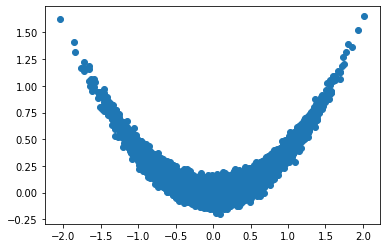

In [2]:
DATASET_SIZE = 20000
BATCH_SIZE = 500
OUTPUT_DIM = 2

params = (0.5,0.1,0.05,0.0) #(a1,a2,a3,theta)
bFlow = BananaFlow(params)
flip = tfb.Permute([1,0])
banana_flipped = flip.forward(bFlow.sample(DATASET_SIZE))


banana_ds = tf.data.Dataset.from_tensor_slices(banana_flipped)
banana_ds = banana_ds.prefetch(tf.data.experimental.AUTOTUNE)
banana_ds = banana_ds.cache()
banana_ds = banana_ds.shuffle(DATASET_SIZE).batch(BATCH_SIZE)

plt.scatter(banana_flipped[:,1], banana_flipped[:, 0])
plt.show()

In [3]:
from transport_nets.models import real_nvp_template
from transport_nets.models import MLP_ODE

class NF_TMAP(tf.keras.Model):
    def __init__(self,nvp_neurons,cnf_neurons,output_dim,block_sizes):
        super(NF_TMAP,self).__init__(name='nf_tmap')
        # n is observable dimension (upper block output dim)
        # m is parameter dimension (lower block output dim)
        n,m = block_sizes
        bijectors = []
        self.shift_scale_fns = []
        self.state_time_fns = []
        self.bn_bijs = []
        self.bn_vars = []
        
        solver = tfp.math.ode.DormandPrince(atol=1e-5)
        ode_solve_fn = solver.solve
        trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        
        mlp_ode = MLP_ODE(output_dim=n,neuron_list=cnf_neurons)
        ffjord_bij = tfb.FFJORD(
                            state_time_derivative_fn=mlp_ode,
                            ode_solve_fn=ode_solve_fn,
                            trace_augmentation_fn=trace_augmentation_fn)
        self.state_time_fns.append(mlp_ode)
        blockwise_ffjord_bij_1 = tfb.Blockwise(
                                    bijectors=[ffjord_bij, tfb.Identity()], 
                                    block_sizes=[n,m])
        
        bn_bij_upper = tfb.BatchNormalization()
        _ = bn_bij_upper(tf.random.normal([1,n]))
        self.bn_bijs.append(bn_bij_upper)
        self.bn_vars.append(bn_bij_upper.trainable_variables)
        bn_bij_lower = tfb.BatchNormalization()
        _ = bn_bij_lower(tf.random.normal([1,m]))
        self.bn_bijs.append(bn_bij_lower)
        self.bn_vars.append(bn_bij_lower.trainable_variables)
        blockwise_bn_1 = tfb.Blockwise(
                            bijectors=[bn_bij_upper,bn_bij_lower])
        
        coupling_nn = real_nvp_template(neuron_list=nvp_neurons)
        nvp_bij_1 = tfb.RealNVP(num_masked = n, 
                            shift_and_log_scale_fn = coupling_nn)
        self.shift_scale_fns.append(coupling_nn)
        
        mlp_ode = MLP_ODE(output_dim=n,neuron_list=cnf_neurons)
        ffjord_bij = tfb.FFJORD(
                            state_time_derivative_fn=mlp_ode,
                            ode_solve_fn=ode_solve_fn,
                            trace_augmentation_fn=trace_augmentation_fn)
        self.state_time_fns.append(mlp_ode)
        blockwise_ffjord_bij_2 = tfb.Blockwise(
                                    bijectors=[tfb.Identity(),ffjord_bij], 
                                    block_sizes=[n,m])
        
        bijectors += [blockwise_ffjord_bij_1,
                      blockwise_bn_1,
                      nvp_bij_1,
                      blockwise_ffjord_bij_2]

        chained_bijectors = tfb.Chain(bijectors[::-1])
        base_loc = tf.zeros([output_dim],dtype=tf.float32)
        base_sigma = tf.ones([output_dim],dtype=tf.float32)
        self.base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
        self.flow = tfd.TransformedDistribution(
                            distribution=self.base_distribution, 
                            bijector=chained_bijectors)
        
    @tf.function   
    def call(self,inputs):
        return self.flow.bijector.forward(inputs)
    
    @tf.function   
    def inverse(self,inputs):
        return self.flow.bijector.inverse(inputs)
    
    @tf.function   
    def sample(self,N):
        return self.flow.sample(N)
    
    @tf.function
    def prob(self, x):
        return self.flow.prob(x)

    @tf.function
    def log_prob(self, x):
        return self.flow.log_prob(x)
    
    @tf.function
    def negative_log_likelihood(self, inputs):
        return -tf.reduce_mean(self.flow.log_prob(inputs))
    
    def compile(self, optimizer):
        super(NF_TMAP, self).compile()
        self.optimizer = optimizer
    
    def training_mode(self,training=True):
        for bij in self.bn_bijs:
            bij.batchnorm.trainable = False
                
    @tf.function
    def train_step(self,target_sample):
        with tf.GradientTape() as tape:
            loss = self.negative_log_likelihood(target_sample)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss
    
    def fit(self,dataset,num_epochs):
        t = trange(num_epochs)
        loss_history = []
        for epoch in t:
            for batch in dataset:
                loss = self.train_step(batch)
                t.set_description("loss: %0.3f " % loss.numpy())
                t.refresh()
                loss_history.append(loss.numpy())
        return loss_history

In [4]:
LR = 1e-4
NUM_EPOCHS = 50
opt = tf.optimizers.Adam(learning_rate=LR,epsilon=1e-8)
nf_tmap = NF_TMAP(nvp_neurons=[100,100],
                  cnf_neurons=[100,100],
                  output_dim = 2,
                  block_sizes =(1,1))
nf_tmap.compile(opt)
loss_history = nf_tmap.fit(banana_ds,NUM_EPOCHS)
nf_tmap.training_mode(False)

loss: -0.767 : 100%|██████████| 50/50 [15:35<00:00, 18.71s/it] 


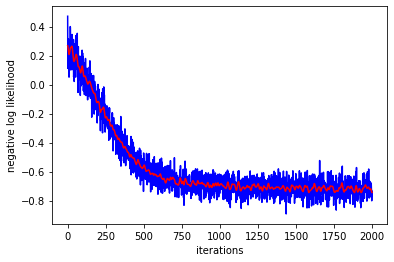

In [5]:
ysmoothed = gaussian_filter1d(loss_history, sigma=4)
plt.plot(loss_history,'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('iterations')
plt.ylabel('negative log likelihood');

In [ ]:
import seaborn as sns
def plot_density(data,axis):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis,
                      levels=20)
xa,xb,ya,yb = (-1.5,1.5,-0.2,0.6)
fig,ax = plt.subplots(1,2,figsize=(10,4))
T = bFlow.sample(10000)
X = nf_tmap.sample(10000)
X_flipped = flip.forward(X)
l1 = plot_density(T,axis=ax[0])
l2 = plot_density(X_flipped,axis=ax[1])
ax[0].set(xlim=(xa,xb),ylim=(ya,yb))
ax[1].set(xlim=(xa,xb),ylim=(ya,yb))

ax[0].set_title('true map')
ax[1].set_title('LT-NF map')
plt.savefig('images/NTNF_kde_final.png')

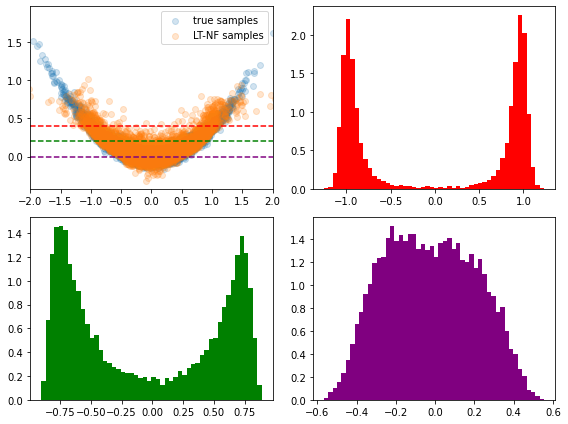

In [8]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
x_obs_list = [0.4,0.2,0.0]
ax[0,0].scatter(T[:,0],T[:,1],alpha=0.2,label='true samples')
ax[0,0].scatter(X_flipped[:,0],X_flipped[:,1],alpha=0.2,label='LT-NF samples')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[0]*np.ones(100),'r--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[1]*np.ones(100),'g--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[2]*np.ones(100),'--',c='purple')
ax[0,0].set_xlim(-2,2)
ax[0,0].legend()

x_obs_list = [0.4,0.2,0.0]
y0 = tf.zeros([1,1])
x_obs1 = tf.constant(x_obs_list[0],shape=[1,1])
x_obs2 = tf.constant(x_obs_list[1],shape=[1,1])
x_obs3 = tf.constant(x_obs_list[2],shape=[1,1])

r1 = nf_tmap.inverse(tf.concat([x_obs1,y0],axis=-1))[0,0]
r2 = nf_tmap.inverse(tf.concat([x_obs2,y0],axis=-1))[0,0]
r3 = nf_tmap.inverse(tf.concat([x_obs3,y0],axis=-1))[0,0]

Ns = 10000

X_cond1 = nf_tmap(tf.concat([r1*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1].numpy()
X_cond2 = nf_tmap(tf.concat([r2*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1].numpy()
X_cond3 = nf_tmap(tf.concat([r3*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1].numpy()

ax[0,1].hist(X_cond1,50,color='r',density=True)
ax[1,0].hist(X_cond2,50,color='g',density=True)
ax[1,1].hist(X_cond3,50,color='purple',density=True)
plt.tight_layout()
plt.savefig('images/LTNF_conditional_samples_final.png')